In [12]:
%%bash
source activate python2
pip install --user FlowCytometryTools

discarding /opt/conda/bin from PATH
prepending /opt/conda/envs/python2/bin to PATH
You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from FlowCytometryTools import FCMeasurement
import pandas as pd
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
def fcs2df(dfSource):
    colNm = ['FSC-A','FSC-H','Width','SSC-A','SSC-H','SSC-W','FL1-A','FL1-H','FL1-W','Time']
    cols = colNm[:]
    [cols.append(item) for item in ['Lab, Strain','bioReplicate','techReplicate']]

    dfNew = pd.DataFrame(columns=cols)
    counts = []
    for i in range(len(dfSource)):
        data = dfSource.loc[i]
        fileNm = data['filePath']
        #print fileNm[-10:]
        sample = FCMeasurement(ID=fileNm,datafile=fileNm)
        dfT = pd.DataFrame(data=sample.data)
        dfT.columns = colNm
        dfT['Lab'] = data['lab']
        dfT['bioReplicate'] = data['bioReplicate']
        dfT['techReplicate'] = data['techReplicate']
        dfT['Strain'] = data['strainID']
        dfNew = pd.concat([dfNew,dfT])
        counts.append(len(dfT))

    dfSource['numCounts'] = counts
    return dfSource, dfNew

In [3]:
def getFiles(folderDir, removeExtras = 0):
    baseDir = '/home/jupyter/sd2e-community/processed_staging/Q0/yeastgates/sd2.ginkgo/flow/tasbe_compliant_20141015/'
    fileList = sorted(os.listdir(baseDir+folderDir))
    fileList = [x for x in fileList if x[-3:] == 'fcs']
    if removeExtras:
        fileList = [x for x in fileList if len(x) < 8]
    filePaths = [baseDir+folderDir+f for f in fileList]
    return fileList, filePaths

In [32]:
def flowViz(df,lab,date):

    n = 1
    channel = 'FL{}'.format(n)
    sns.set_style('ticks')
    fig, ax = plt.subplots(4,2,figsize=(8,11),sharex=True)
    sns.set_palette('cubehelix',3)
    cond = ['XOR_00','XOR_01','XOR_10','XOR_11']
    for c, axR in zip(cond,range(4)):
        ax[axR,0].annotate(c,(0.05,0.85),xycoords='axes fraction')
        dfT = df[df['Strain'] == c]
        for samp in sorted(set(dfT.bioReplicate)):
            data = dfT[dfT['bioReplicate'] == samp]['{}-H'.format(channel)]
            sns.distplot(np.log10(data[data > 0]),hist=False,ax = ax[axR,0])
            ax[axR,0].legend(['R1','R2','R3'],loc='upper left')
            ax[axR,0].set_xlim([1,5])
            data = dfT[dfT['bioReplicate'] == samp]['{}-A'.format(channel)]
            sns.distplot(np.log10(data[data > 0]),hist=False,ax = ax[axR,1])
            ax[axR,1].legend(['R1','R2','R3'])
            ax[axR,1].set_xlim([1,5])
    sns.despine()
    fig.savefig(outputDir+'plots/{}_flow_{}_{}.pdf'.format(lab,channel,date))

### Ginkgo pre-measurement dataframe

In [5]:
originatorLab = 'Ginkgo'
flowDate = '2017_preMeasurement'

In [6]:
colNames = ['date','lab','well','strainID','bioReplicate',
            'techReplicate','filePath']

folderDir = 'yeast-gates-biological-replicate-1-pre-measurement/reps/'
fileList, filePaths = getFiles(folderDir, removeExtras = 0)

date = [flowDate for i in range(5)]
lab = [originatorLab for i in range (5)]
well = ['B01','B07','D01','F01','H01']
strainList = ['XOR_00','Beads','XOR_01','XOR_10','XOR_11']
strainID = strainList
bioRep = [1 for r in range(5)]
techRep = [1 for i in range(5)]
frame = [date, lab, well, strainID, bioRep, techRep, filePaths]
dfP1 = pd.DataFrame(frame).transpose()
dfP1.columns = colNames

In [7]:
folderDir = 'yeast-gates-biological-replicate-2-pre-measurement/reps/'
fileList, filePaths = getFiles(folderDir, removeExtras = 0)

date = [flowDate for i in range(4)]
lab = [originatorLab for i in range (4)]
well = ['A01','C01','E01','G01']
strainList = ['XOR_00','XOR_01','XOR_10','XOR_11']
strainID = strainList
bioRep = [2 for r in range(4)]
techRep = [1 for i in range(4)]
colNames = ['date','lab','well','strainID','bioReplicate',
            'techReplicate','filePath']
frame = [date, lab, well, strainID, bioRep, techRep, filePaths]
dfP2 = pd.DataFrame(frame).transpose()
dfP2.columns = colNames

In [8]:
folderDir = 'yeast-gates-biological-replicate-3-pre-measurement/reps/'
fileList, filePaths = getFiles(folderDir, removeExtras = 0)
reps = 2

date = [flowDate for i in range(4*reps+1)]
lab = [originatorLab for i in range (4*reps+1)]
well = ['A{:02d}'.format(i) for i in range(2,10+1)]
strainList = ['XOR_{}'.format(type) for type in ['00','01','10','11']
             for rep in range(reps)]
strainList.append('Beads')
strainID = strainList
bioRep = [3 for r in range(4*reps+1)]
techRep = [1,2,1,2,1,2,1,2,1]
colNames = ['date','lab','well','strainID','bioReplicate',
            'techReplicate','filePath']
frame = [date, lab, well, strainID, bioRep, techRep, filePaths]
dfP3 = pd.DataFrame(frame).transpose()
dfP3.columns = colNames

In [9]:
dfP = pd.concat([dfP1,dfP2,dfP3])
dfP = dfP.reset_index(drop=True)

## Convert fcs files to dataframe

In [10]:
outputDir = '/home/jupyter/sd2e-community/shared-q0-hackathon/yeast-gates/flowDataFrames/Ginkgo/'

dfP, dfFCSp = fcs2df(dfP)
dfP.to_csv(outputDir+'{}_{}_sampleTable.csv'.format(originatorLab,flowDate))
dfFCSp.to_csv(outputDir+'{}_{}_flowDataFrame.csv'.format(originatorLab,flowDate))

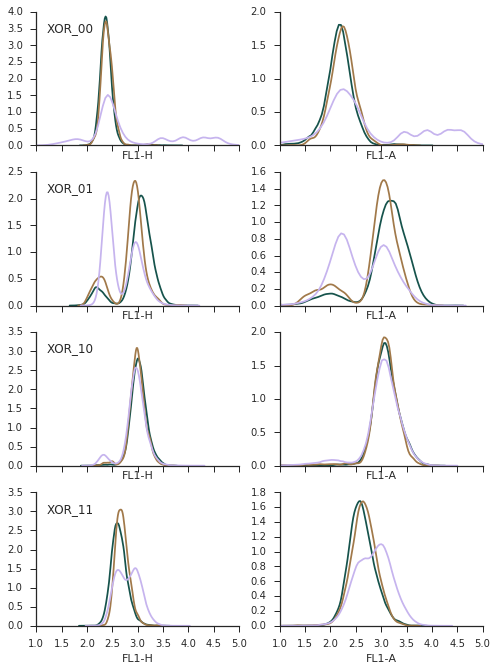

In [33]:
flowViz(dfFCSp,originatorLab,flowDate)

### Ginkgo final measurement dataframe

In [25]:
flowDate = '2017_finalMeasurement'
originatorLab = 'Ginkgo'

In [26]:
colNames = ['date','lab','well','strainID','bioReplicate',
            'techReplicate','filePath']

folderDir = 'yeast-gates-biological-replicate-1-final-measurement-failure/reps/'
fileList, filePaths = getFiles(folderDir, removeExtras = 0)
reps = 2

date = [flowDate for i in range(2*reps)]
lab = [originatorLab for i in range (2*reps)]
well = ['A02','A07','C02','C07']
strainList = ['XOR_00','XOR_01','XOR_00','XOR_01']
strainID = strainList
bioRep = [1 for r in range(2*reps)]
techRep = [1,2,1,2]
frame = [date, lab, well, strainID, bioRep, techRep, filePaths]
dfF1 = pd.DataFrame(frame).transpose()
dfF1.columns = colNames

In [27]:
folderDir = 'yeast-gates-biological-replicate-2-final-measurement/reps/'
fileList, filePaths = getFiles(folderDir, removeExtras = 0)
reps = 2

date = [flowDate for i in range(4*reps+1)]
lab = [originatorLab for i in range (4*reps+1)]
well = ['A{:02d}'.format(i) for i in range(1,9+1)]
strainList = ['XOR_{}'.format(type) for type in ['00','01','10','11']
             for rep in range(reps)]
strainList.append('Beads')
bioRep = [2 for r in range(4*reps+1)]
techRep = [1,2,1,2,1,2,1,2,1]
colNames = ['date','lab','well','strainID','bioReplicate',
            'techReplicate','filePath']
frame = [date, lab, well, strainID, bioRep, techRep, filePaths]
dfF2 = pd.DataFrame(frame).transpose()
dfF2.columns = colNames

In [28]:
folderDir = 'yeast-gates-biological-replicate-3-final-measurement/reps/'
fileList, filePaths = getFiles(folderDir, removeExtras = 0)
reps = 2

date = [flowDate for i in range(4*reps+1)]
lab = [originatorLab for i in range (4*reps+1)]
well = ['B{:02d}'.format(i) for i in range(1,9+1)]
strainList = ['XOR_{}'.format(type) for type in ['00','01','10','11']
             for rep in range(reps)]
strainList.append('Beads')
strainID = strainList
bioRep = [3 for r in range(4*reps+1)]
techRep = [1,2,1,2,1,2,1,2,1]
colNames = ['date','lab','well','strainID','bioReplicate',
            'techReplicate','filePath']
frame = [date, lab, well, strainID, bioRep, techRep, filePaths]
dfF3 = pd.DataFrame(frame).transpose()
dfF3.columns = colNames

In [29]:
dfF = pd.concat([dfF1,dfF2,dfF3])
dfF = dfF.reset_index(drop=True)

### Concatenate fcs data into dataframe

In [30]:
outputDir = '/home/jupyter/sd2e-community/shared-q0-hackathon/yeast-gates/flowDataFrames/Ginkgo/'

dfF, dfFCSf = fcs2df(dfF)
dfF.to_csv(outputDir+'{}_{}_sampleTable.csv'.format(originatorLab,flowDate))
dfFCSf.to_csv(outputDir+'{}_{}_flowDataFrame.csv'.format(originatorLab,flowDate))

### Visualize flow data

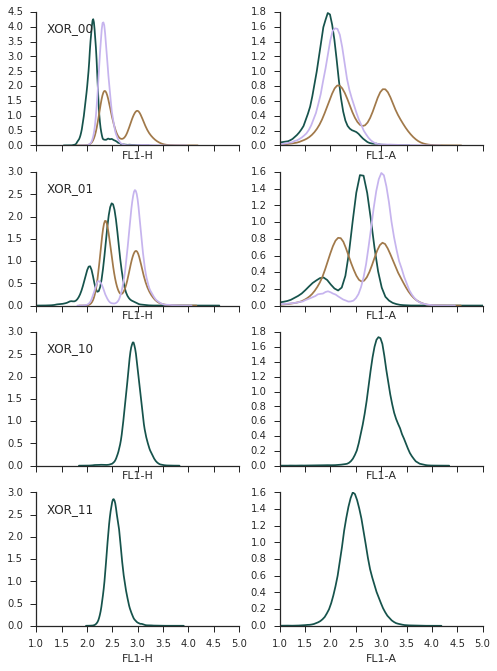

In [34]:
flowViz(dfFCSf,originatorLab,flowDate)

## FSC/SSC scatter

In [100]:
test = dfFCSp[dfFCSp['Strain'] == 'WT']
test = test[test['bioReplicate'] == 1]
test = test[test['FSC-A'] < 3e6]
test = test[test['FSC-H'] < 3.5e6]

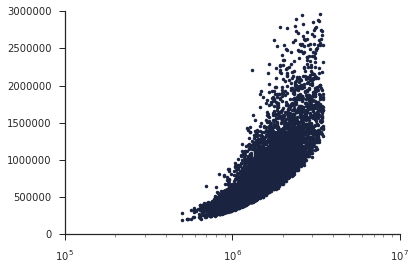

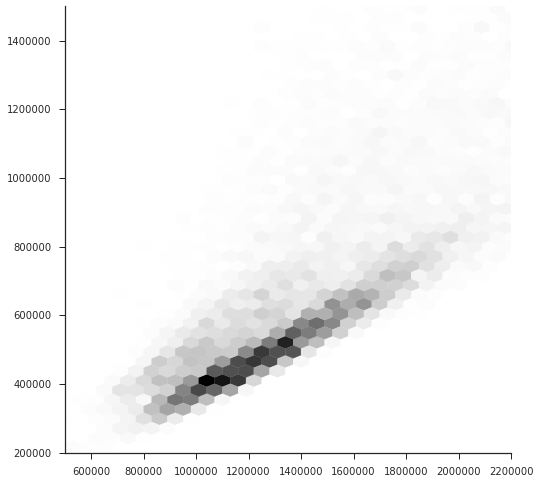

In [109]:
plt.plot(test['FSC-H'],test['FSC-A'],'.')
plt.xscale('log')
#plt.yscale('log')
sns.despine()

#sns.kdeplot(test[['FSC-H','FSC-A']])
fig,ax = plt.subplots(1,1,figsize=(8,8))
#fig = sns.jointplot("FSC-H", "FSC-A", data=test, size = 8, ratio=10, kind="hex")
ax.hexbin(test['FSC-H'],test['FSC-A'],gridsize=(50,50))
ax.set_xlim([5e5,2.2e6])
ax.set_ylim([2e5,1.5e6])
sns.despine()